Considerando a regionalidade do SESI, poderiamos combinar os dados do pysus com ibge atraves 
from pysus.online_data import IBGE
pop = IBGE.get_population(source="POP", year=2010)
pop
Ou simplesmente regionalizar o estudo, aqui se der tempo vou tentar ver o que tem maior ocorrencia por estado e plotar em barras empilhadas com numero de casos/pop

In [1]:
#!pip install pysus
#!pip install geopandas

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('df_acgr.csv')

C:\Users\Administrador\AppData\Local\Temp\ipykernel_15700\977782822.py:1: DtypeWarning: Columns (3,10,21,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_acgr.csv')


In [4]:
def decodifica_idade_SINAN(idade_codificada):
    valor_str = str(idade_codificada)  # Converte o valor para string
    primeiro_digito = int(valor_str[0])  # Pega o primeiro dígito
    
    if primeiro_digito == 4:
        return int(valor_str[1:])  # Retorna os próximos dígitos
    elif primeiro_digito in [1, 2, 3]:
        return 0  # Retorna 0 para os primeiros dígitos 1, 2 ou 3
    else:
        return idade_codificada  # Retorna o valor original, caso não se enquadre nas condições



In [5]:
# Convertendo colunas de data
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'])
df['Ano_Mes'] = df['DT_NOTIFIC'].dt.to_period('M')
df['NU_IDADE_N'] = df['NU_IDADE_N'].apply(decodifica_idade_SINAN)

In [6]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

# Exemplo de pré-processamento para a seleção de colunas
df_cluster = df[['DT_NOTIFIC', 'SG_UF_NOT', 'NU_IDADE_N', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_OCUPA_N', 
                           'SIT_TRAB', 'NUTEMPO', 'TPTEMPO', 'LOCAL_ACID', 'UF_EMP', 'MUN_EMP', 
                           'TERCEIRIZA', 'HORA_JOR', 'MIN_JOR', 'TIPO_ACID']]


# Convertendo as colunas numéricas para o tipo adequado
numeric_cols = ['NUTEMPO', 'TPTEMPO', 'HORA_JOR', 'MIN_JOR', 'TERCEIRIZA']

# Convertendo para numérico, forçando erros para NaN e tratando
df_cluster[numeric_cols] = df_cluster[numeric_cols].apply(pd.to_numeric, errors='coerce')
# Garantindo que as variáveis numéricas sejam tratadas como float
df_cluster[numeric_cols] = df_cluster[numeric_cols].astype(float)

# Tratando valores nulos nas variáveis numéricas
df_cluster[numeric_cols] = df_cluster[numeric_cols].fillna(df_cluster[numeric_cols].mean())



# Codificando variáveis categóricas
categorical_cols = ['SG_UF_NOT',  'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_OCUPA_N', 'SIT_TRAB', 'LOCAL_ACID', 'UF_EMP', 'MUN_EMP', 
                    'TIPO_ACID']

# Garantir que todas as colunas categóricas sejam do tipo string
df_cluster[categorical_cols] = df_cluster[categorical_cols].astype(str)
# Preenchendo os valores nulos nas colunas categóricas (com o valor 'Desconhecido', por exemplo)
df_cluster[categorical_cols] = df_cluster[categorical_cols].fillna('Desconhecido')


encoder = OneHotEncoder(drop='first', sparse_output=True)
# Matriz esparsa
encoded_data_sparse = encoder.fit_transform(df_cluster[categorical_cols])

# Transformando variáveis numéricas
numeric_cols = [ 'NU_IDADE_N', 'NUTEMPO', 'TPTEMPO', 'HORA_JOR', 'MIN_JOR', 'TERCEIRIZA']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster[numeric_cols])
# Convertendo scaled_data para uma matriz esparsa
scaled_data_sparse = csr_matrix(scaled_data)



# Combina as duas matrizes esparsas
processed_data_sparse = hstack([encoded_data_sparse, scaled_data_sparse])

C:\Users\Administrador\AppData\Local\Temp\ipykernel_15700\308611577.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster[numeric_cols] = df_cluster[numeric_cols].apply(pd.to_numeric, errors='coerce')
C:\Users\Administrador\AppData\Local\Temp\ipykernel_15700\308611577.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster[numeric_cols] = df_cluster[numeric_cols].astype(float)
C:\Users\Administrador\AppData\Local\Temp\ipykernel_15700\308611577.py:19: SettingWithCopyWarning: 
A value is try

In [7]:
# Definindo o número de clusters (ajuste conforme necessário)
kmeans = KMeans(n_clusters=3, random_state=42)

# Aplicando o KMeans nos dados
clusters = kmeans.fit_predict(processed_data_sparse)

# Adicionando os resultados ao DataFrame
df_cluster['Cluster'] = clusters

# Visualizando os resultados
df_cluster.groupby('Cluster').size()


C:\Users\Administrador\AppData\Local\Temp\ipykernel_15700\4150859158.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['Cluster'] = clusters


Cluster
0     795989
1    1318678
2     257472
dtype: int64

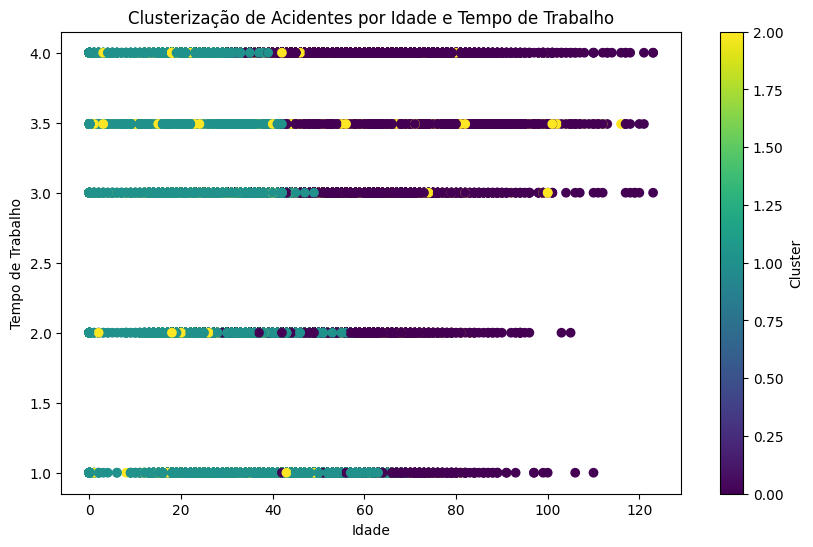

In [8]:
import matplotlib.pyplot as plt

# Plotando os clusters em um gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_cluster['NU_IDADE_N'], df_cluster['TPTEMPO'], c=df_cluster['Cluster'], cmap='viridis')
plt.xlabel('Idade')
plt.ylabel('Tempo de Trabalho')
plt.title('Clusterização de Acidentes por Idade e Tempo de Trabalho')
plt.colorbar(label='Cluster')
plt.show()


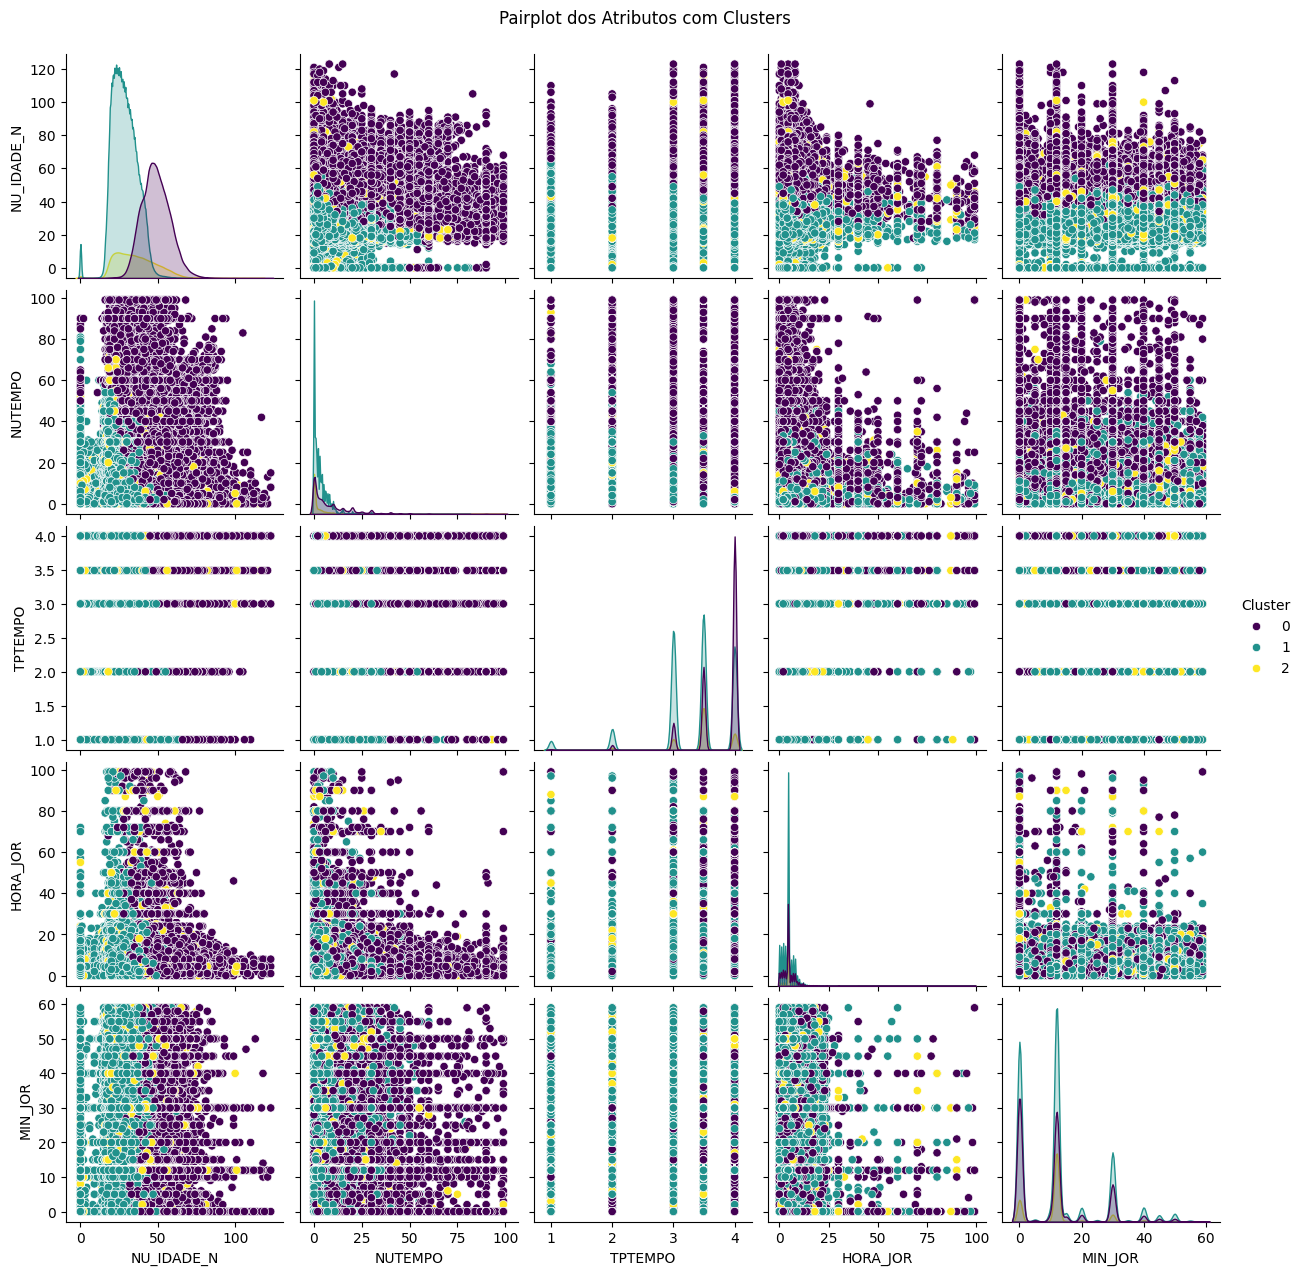

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


# Selecionando apenas colunas numéricas para o pairplot
pairplot_cols = ['NU_IDADE_N', 'NUTEMPO', 'TPTEMPO', 'HORA_JOR', 'MIN_JOR']

# Criando o pairplot
sns.pairplot(df_cluster[pairplot_cols + ['Cluster']], hue='Cluster', palette='viridis', diag_kind='kde')

plt.suptitle('Pairplot dos Atributos com Clusters', y=1.02)
plt.show()


In [11]:
for col in categorical_cols:
    print(f"\nTabela de Frequência para {col}")
    print(pd.crosstab(df_cluster[col], df_cluster['Cluster'], normalize='index').round(2))


Tabela de Frequência para SG_UF_NOT
Cluster       0     1     2
SG_UF_NOT                  
11.0       0.37  0.56  0.06
12.0       0.45  0.50  0.06
13.0       0.35  0.58  0.07
14.0       0.32  0.58  0.10
15.0       0.36  0.55  0.09
16.0       0.38  0.54  0.09
17.0       0.45  0.53  0.02
21.0       0.41  0.50  0.09
22.0       0.43  0.39  0.17
23.0       0.41  0.54  0.05
24.0       0.31  0.44  0.25
25.0       0.21  0.34  0.44
26.0       0.38  0.45  0.17
27.0       0.26  0.50  0.24
28.0       0.37  0.54  0.09
29.0       0.31  0.41  0.27
31.0       0.38  0.53  0.08
32.0       0.41  0.53  0.07
33.0       0.31  0.46  0.23
35.0       0.28  0.61  0.11
41.0       0.37  0.57  0.07
42.0       0.38  0.59  0.03
43.0       0.39  0.56  0.06
50.0       0.33  0.52  0.15
51.0       0.34  0.61  0.05
52.0       0.36  0.54  0.10
53.0       0.29  0.43  0.28
nan        0.00  0.67  0.33

Tabela de Frequência para CS_SEXO
Cluster     0     1     2
CS_SEXO                  
F        0.37  0.54  0.09
I        0

<Figure size 1000x500 with 0 Axes>

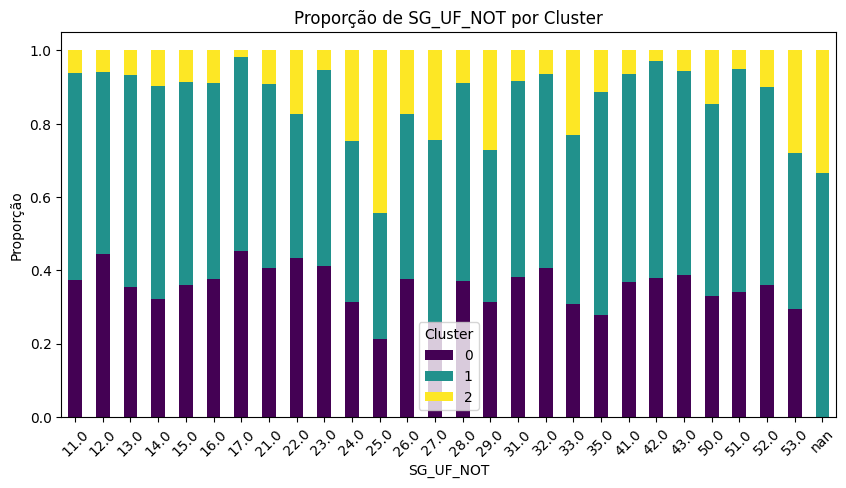

<Figure size 1000x500 with 0 Axes>

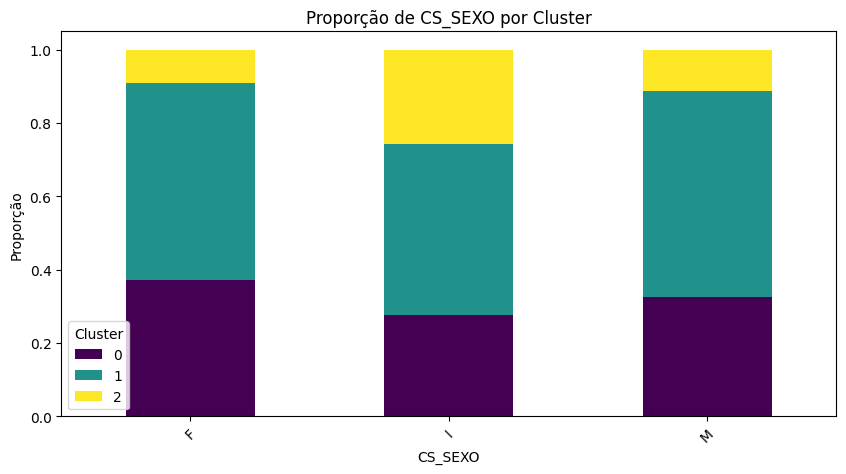

<Figure size 1000x500 with 0 Axes>

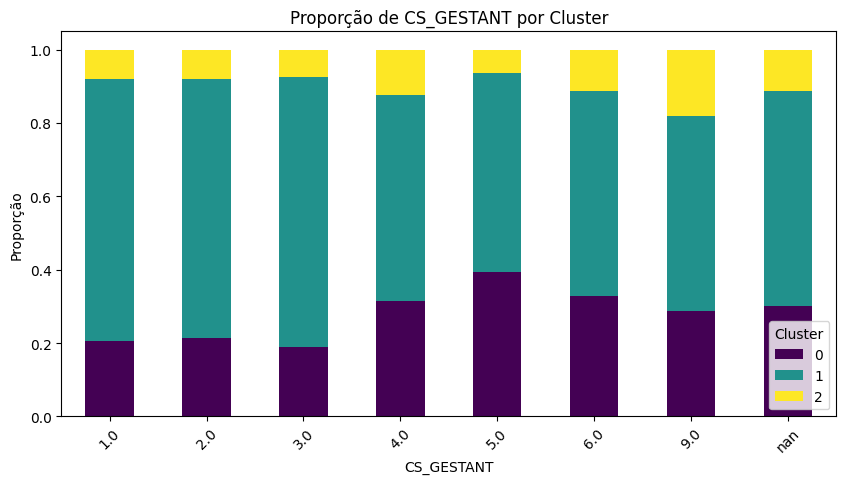

<Figure size 1000x500 with 0 Axes>

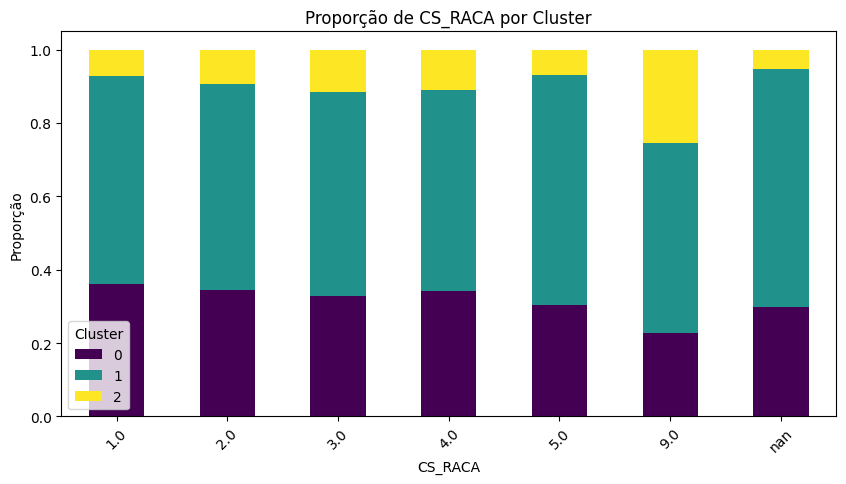

<Figure size 1000x500 with 0 Axes>

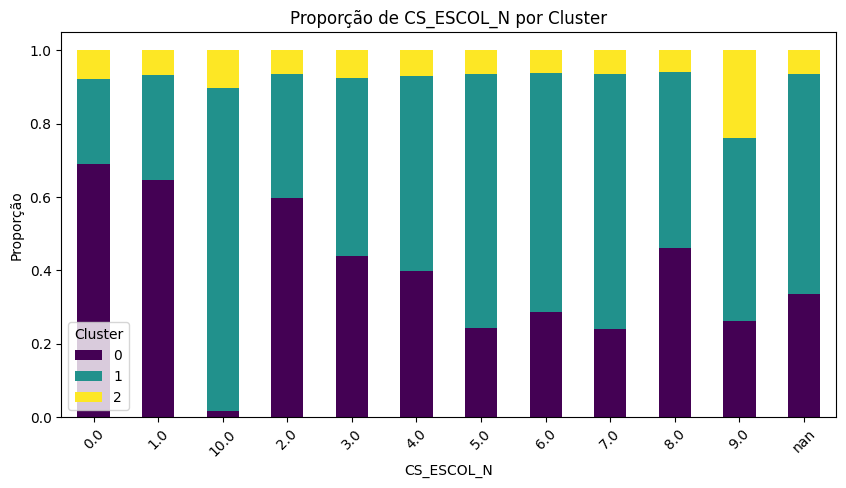

<Figure size 1000x500 with 0 Axes>

C:\Users\Administrador\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


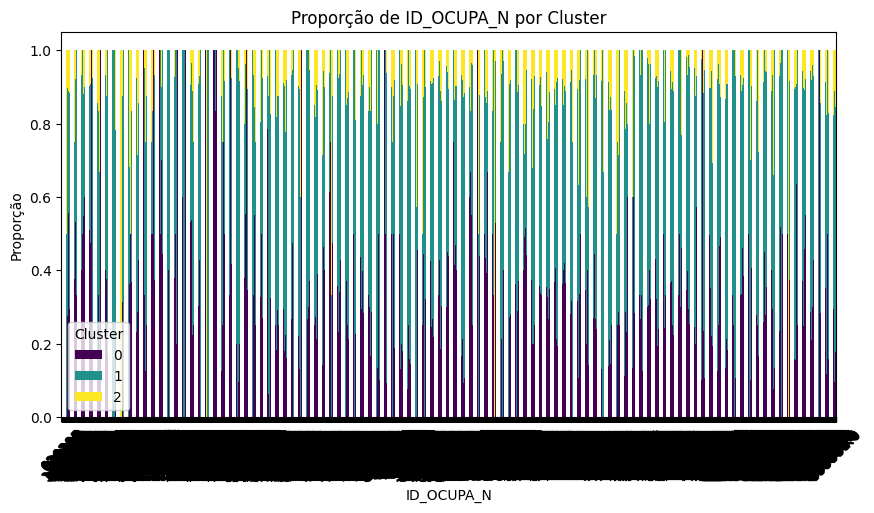

<Figure size 1000x500 with 0 Axes>

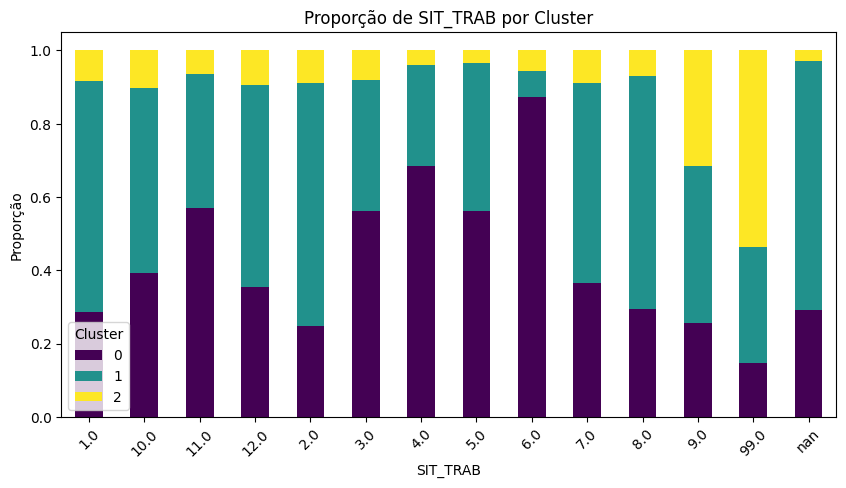

<Figure size 1000x500 with 0 Axes>

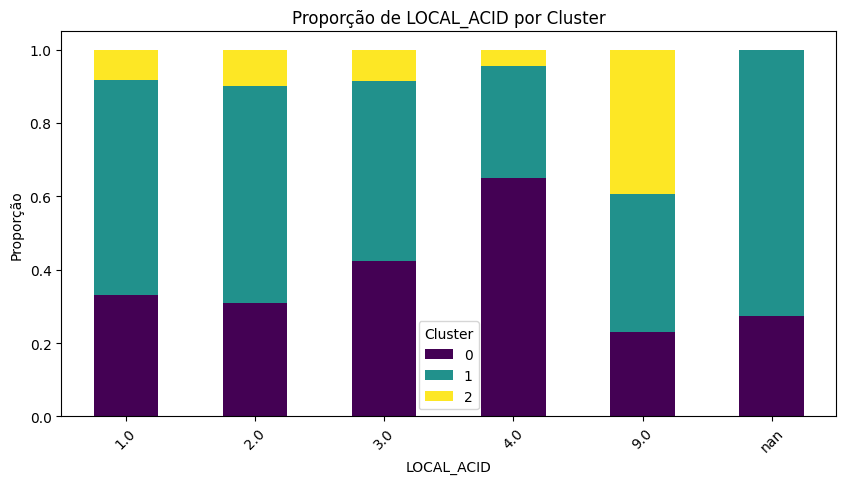

<Figure size 1000x500 with 0 Axes>

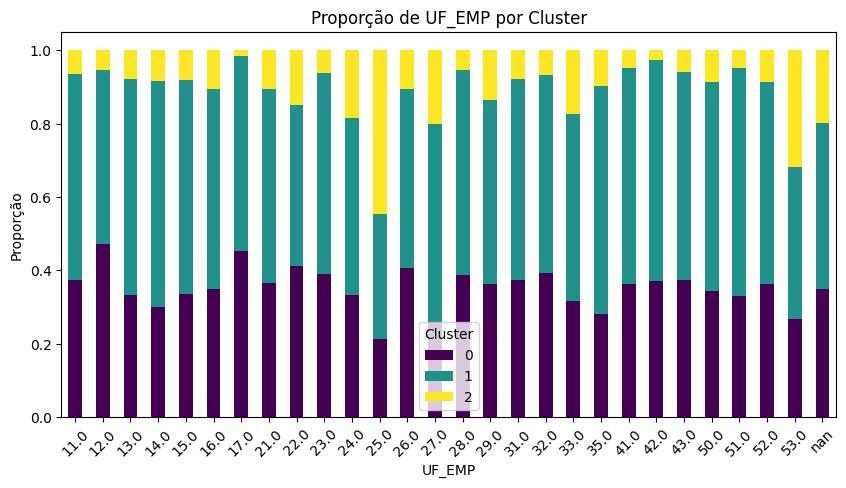

<Figure size 1000x500 with 0 Axes>

C:\Users\Administrador\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


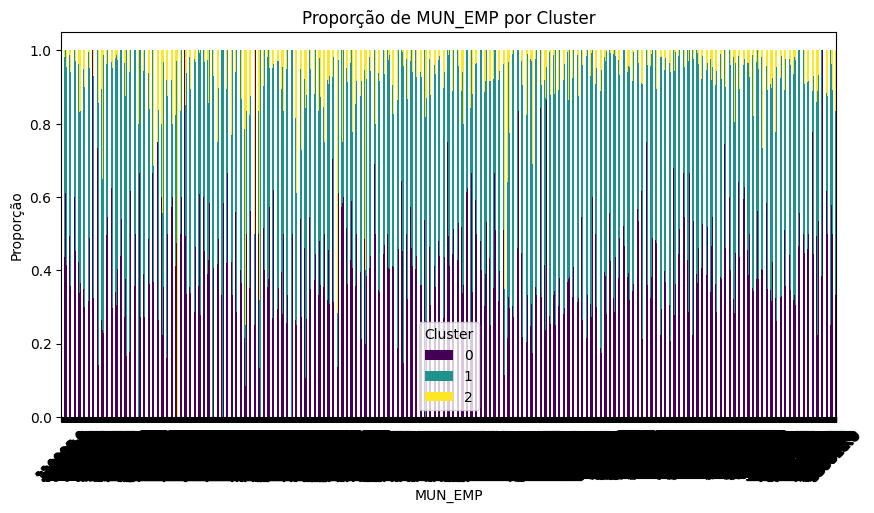

<Figure size 1000x500 with 0 Axes>

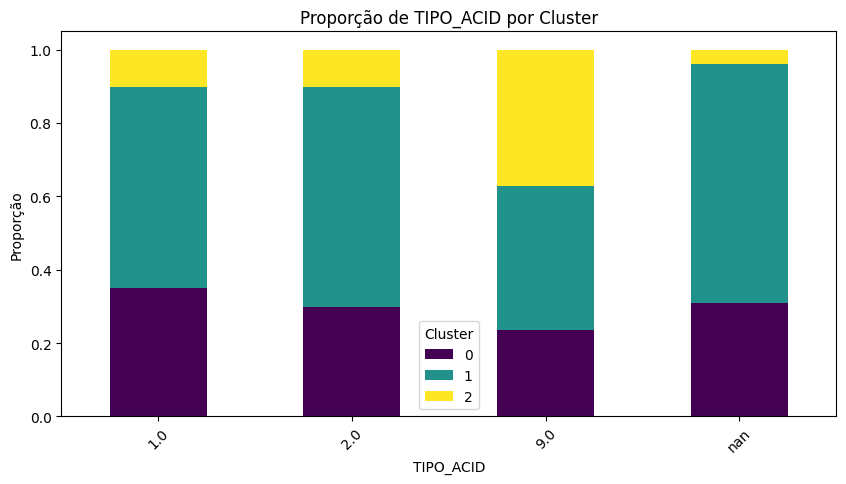

In [12]:

for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    prop_df = df_cluster.groupby(col)['Cluster'].value_counts(normalize=True).unstack()
    prop_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 5))
    plt.title(f'Proporção de {col} por Cluster')
    plt.ylabel('Proporção')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.show()